In [25]:
import numpy as np
import pandas as pd

from sklearn.preprocessing import OneHotEncoder
import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.activations import relu, selu
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import categorical_accuracy
from tensorflow.keras.losses import sparse_categorical_crossentropy
from tensorflow.keras.utils import to_categorical, plot_model

In [26]:
data = pd.read_csv('WineData.csv')
data.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5


In [27]:
data.shape

(1599, 12)

In [28]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1599 entries, 0 to 1598
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   fixed acidity         1599 non-null   float64
 1   volatile acidity      1599 non-null   float64
 2   citric acid           1599 non-null   float64
 3   residual sugar        1599 non-null   float64
 4   chlorides             1599 non-null   float64
 5   free sulfur dioxide   1599 non-null   float64
 6   total sulfur dioxide  1599 non-null   float64
 7   density               1599 non-null   float64
 8   pH                    1599 non-null   float64
 9   sulphates             1599 non-null   float64
 10  alcohol               1599 non-null   float64
 11  quality               1599 non-null   int64  
dtypes: float64(11), int64(1)
memory usage: 150.0 KB


In [29]:
data.describe()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
count,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000
mean,8.319637,0.527821,0.270976,2.538806,0.087467,15.874922,46.467792,0.996747,3.311113,0.658149,10.422983,5.636023
std,1.741096,0.179060,0.194801,1.409928,0.047065,10.460157,32.895324,0.001887,0.154386,0.169507,1.065668,0.807569
min,4.600000,0.120000,0.000000,0.900000,0.012000,1.000000,6.000000,0.990070,2.740000,0.330000,8.400000,3.000000
25%,7.100000,0.390000,0.090000,1.900000,0.070000,7.000000,22.000000,0.995600,3.210000,0.550000,9.500000,5.000000
50%,7.900000,0.520000,0.260000,2.200000,0.079000,14.000000,38.000000,0.996750,3.310000,0.620000,10.200000,6.000000
75%,9.200000,0.640000,0.420000,2.600000,0.090000,21.000000,62.000000,0.997835,3.400000,0.730000,11.100000,6.000000
max,15.900000,1.580000,1.000000,15.500000,0.611000,72.000000,289.000000,1.003690,4.010000,2.000000,14.900000,8.000000


Split into train and test

In [30]:
from sklearn.model_selection import train_test_split

data_train, data_test = train_test_split(data, test_size = 0.25, random_state = 42)

In [31]:
print("Size of training data:", data_train.shape)
print("Size of test data:", data_test.shape)

Size of training data: (1199, 12)
Size of test data: (400, 12)


Acceptable inputs to ANN TF models are np array and tensors.<br>
Converting the input to those formats

In [32]:
X_train = data_train.drop("quality", axis=1).to_numpy()
y_train = data_train["quality"].to_numpy()

X_test = data_test.drop("quality", axis=1).to_numpy()
y_test = data_test["quality"].to_numpy()

print('X_train shape:', X_train.shape)
print('y_train shape:', y_train.shape)
print('X_train shape:', X_test.shape)
print('y_test shape:', y_test.shape)

X_train shape: (1199, 11)
y_train shape: (1199,)
X_train shape: (400, 11)
y_test shape: (400,)


In [33]:
y_train1 = y_train.copy()
y_test1 = y_test.copy()

y_train = y_train.reshape(-1, 1)
encoder = OneHotEncoder(sparse=False)
y_train = encoder.fit_transform(y_train)

In [34]:
y_train[0:5]

array([[0., 0., 1., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0.],
       [0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0.]])

Build a data processing function to add new features 

In [35]:
from sklearn.base import BaseEstimator, TransformerMixin

# column indexes
density_ix, alcohol_ix, volAcidty_ix, pH_ix, freeSO2_ix, totalSO2_ix, sulphates_ix  = 7, 10, 1, 8, 5, 6, 9

class featureAdder(BaseEstimator, TransformerMixin):
    def __init__(self, addFeature = False):
        self.addFeature = addFeature
        return None
    
    def fit(self, X, y = None):
        return self
    
    def transform(self, X):
        if self.addFeature:
            densityByPH = X[:, density_ix] / X[:, pH_ix]
            alcoholByPH = X[:, alcohol_ix] / X[:, pH_ix]
            alcoholByVolAcidity = X[:, alcohol_ix] / X[:, volAcidty_ix]
            freeByTotalSO2 = X[:, freeSO2_ix] / X[:, totalSO2_ix]
            
            return np.c_[X, densityByPH, alcoholByPH, alcoholByVolAcidity, freeByTotalSO2]
        
        else:
            return X

In [36]:
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

# Create a pipeline

basePipeline = Pipeline([
    ('addFeature',featureAdder()),
    ('scaler', StandardScaler())
])

featPipeline = Pipeline([
    ('addFeature', featureAdder(addFeature=True)),
    ('scaler', StandardScaler())
])

X_trainBase = basePipeline.fit_transform(X_train)
X_trainFeat = featPipeline.fit_transform(X_train)

In [37]:
print('X_trainBase shape:',X_trainBase.shape)
print('X_trainFeat shape:',X_trainFeat.shape)
print('y_train shape:',y_train.shape)

X_trainBase shape: (1199, 11)
X_trainFeat shape: (1199, 15)
y_train shape: (1199, 6)


Build the sequential model

In [38]:
keras.backend.clear_session() # clearing session
np.random.seed(42) # generating random see
tf.random.set_seed(42) # set.seed function helps reuse same set of random variables

In [39]:
baseModel = Sequential([
    Dense(300, input_shape = [11,] , activation = 'selu', kernel_initializer="lecun_normal"),
    Dense(100, activation = 'selu', kernel_initializer="lecun_normal"),
    Dense(100, activation = 'selu', kernel_initializer="lecun_normal"),
    Dense(100, activation = 'selu', kernel_initializer="lecun_normal"),
    Dense(6,  activation = 'softmax')
]) 

featModel = Sequential([
    Dense(300, input_shape = [15,] , activation = 'selu', kernel_initializer="lecun_normal"),
    Dense(100, activation = 'selu', kernel_initializer="lecun_normal"),
    Dense(100, activation = 'selu', kernel_initializer="lecun_normal"),
    Dense(100, activation = 'selu', kernel_initializer="lecun_normal"),
    Dense(6,  activation = 'softmax')
])

In [40]:
baseModel.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 300)               3600      
_________________________________________________________________
dense_1 (Dense)              (None, 100)               30100     
_________________________________________________________________
dense_2 (Dense)              (None, 100)               10100     
_________________________________________________________________
dense_3 (Dense)              (None, 100)               10100     
_________________________________________________________________
dense_4 (Dense)              (None, 6)                 606       
Total params: 54,506
Trainable params: 54,506
Non-trainable params: 0
_________________________________________________________________


In [41]:
featModel.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_5 (Dense)              (None, 300)               4800      
_________________________________________________________________
dense_6 (Dense)              (None, 100)               30100     
_________________________________________________________________
dense_7 (Dense)              (None, 100)               10100     
_________________________________________________________________
dense_8 (Dense)              (None, 100)               10100     
_________________________________________________________________
dense_9 (Dense)              (None, 6)                 606       
Total params: 55,706
Trainable params: 55,706
Non-trainable params: 0
_________________________________________________________________


In [42]:
# keras.utils.plot_model(sqModel, show_shapes=True)

In [43]:
opt = Adam(learning_rate= 0.0001)
loss = 'categorical_crossentropy'
metrics = 'accuracy'
#early_stopping_cb = keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)

baseModel.compile(optimizer= opt, loss= loss , metrics= [metrics])
featModel.compile(optimizer= opt, loss= loss , metrics= [metrics])

In [44]:
baseHistory = baseModel.fit(X_trainBase, y_train, epochs =100)

Train on 1199 samples
Epoch 1/100
1199/1199 [==============================] - 0s 345us/sample - loss: 1.6852 - accuracy: 0.3862
Epoch 2/100
1199/1199 [==============================] - 0s 50us/sample - loss: 1.2868 - accuracy: 0.5405
Epoch 3/100
1199/1199 [==============================] - 0s 54us/sample - loss: 1.1573 - accuracy: 0.5638
Epoch 4/100
1199/1199 [==============================] - 0s 52us/sample - loss: 1.0828 - accuracy: 0.5897
Epoch 5/100
1199/1199 [==============================] - 0s 54us/sample - loss: 1.0261 - accuracy: 0.5922
Epoch 6/100
1199/1199 [==============================] - 0s 57us/sample - loss: 0.9813 - accuracy: 0.6138
Epoch 7/100
1199/1199 [==============================] - 0s 58us/sample - loss: 0.9536 - accuracy: 0.6280
Epoch 8/100
1199/1199 [==============================] - 0s 55us/sample - loss: 0.9348 - accuracy: 0.6205
Epoch 9/100
1199/1199 [==============================] - 0s 54us/sample - loss: 0.9097 - accuracy: 0.6247
Epoch 10/100
1199/1199 

1199/1199 [==============================] - 0s 43us/sample - loss: 0.5808 - accuracy: 0.7773
Epoch 78/100
1199/1199 [==============================] - 0s 48us/sample - loss: 0.5763 - accuracy: 0.7756
Epoch 79/100
1199/1199 [==============================] - 0s 49us/sample - loss: 0.5703 - accuracy: 0.7731
Epoch 80/100
1199/1199 [==============================] - 0s 48us/sample - loss: 0.5661 - accuracy: 0.7748
Epoch 81/100
1199/1199 [==============================] - 0s 49us/sample - loss: 0.5740 - accuracy: 0.7731
Epoch 82/100
1199/1199 [==============================] - 0s 47us/sample - loss: 0.5624 - accuracy: 0.7857
Epoch 83/100
1199/1199 [==============================] - 0s 50us/sample - loss: 0.5572 - accuracy: 0.7898
Epoch 84/100
1199/1199 [==============================] - 0s 50us/sample - loss: 0.5517 - accuracy: 0.7815
Epoch 85/100
1199/1199 [==============================] - 0s 48us/sample - loss: 0.5509 - accuracy: 0.7907
Epoch 86/100
1199/1199 [==========================

In [45]:
featHistory = featModel.fit(X_trainFeat, y_train, epochs =100)

Train on 1199 samples
Epoch 1/100
1199/1199 [==============================] - 0s 325us/sample - loss: 1.3702 - accuracy: 0.5113
Epoch 2/100
1199/1199 [==============================] - 0s 56us/sample - loss: 0.9943 - accuracy: 0.5905
Epoch 3/100
1199/1199 [==============================] - 0s 53us/sample - loss: 0.9220 - accuracy: 0.6038
Epoch 4/100
1199/1199 [==============================] - 0s 51us/sample - loss: 0.8871 - accuracy: 0.6355
Epoch 5/100
1199/1199 [==============================] - 0s 51us/sample - loss: 0.8599 - accuracy: 0.6397
Epoch 6/100
1199/1199 [==============================] - 0s 54us/sample - loss: 0.8346 - accuracy: 0.6589
Epoch 7/100
1199/1199 [==============================] - 0s 54us/sample - loss: 0.8253 - accuracy: 0.6564
Epoch 8/100
1199/1199 [==============================] - 0s 56us/sample - loss: 0.8119 - accuracy: 0.6681
Epoch 9/100
1199/1199 [==============================] - 0s 55us/sample - loss: 0.7975 - accuracy: 0.6681
Epoch 10/100
1199/1199 

1199/1199 [==============================] - 0s 54us/sample - loss: 0.4894 - accuracy: 0.8215
Epoch 78/100
1199/1199 [==============================] - 0s 48us/sample - loss: 0.4930 - accuracy: 0.8082
Epoch 79/100
1199/1199 [==============================] - 0s 49us/sample - loss: 0.4853 - accuracy: 0.8299
Epoch 80/100
1199/1199 [==============================] - 0s 49us/sample - loss: 0.4811 - accuracy: 0.8307
Epoch 81/100
1199/1199 [==============================] - 0s 49us/sample - loss: 0.4833 - accuracy: 0.8282
Epoch 82/100
1199/1199 [==============================] - 0s 50us/sample - loss: 0.4764 - accuracy: 0.8340
Epoch 83/100
1199/1199 [==============================] - 0s 47us/sample - loss: 0.4695 - accuracy: 0.8340
Epoch 84/100
1199/1199 [==============================] - 0s 49us/sample - loss: 0.4659 - accuracy: 0.8315
Epoch 85/100
1199/1199 [==============================] - 0s 49us/sample - loss: 0.4670 - accuracy: 0.8357
Epoch 86/100
1199/1199 [==========================

In [46]:
X_testBase = basePipeline.transform(X_test)
X_testFeat = featPipeline.transform(X_test)

y_test = y_test.reshape(-1, 1)
y_test = encoder.transform(y_test)

print('X_testBase shape:',X_testBase.shape)
print('X_testFeat shape:',X_testFeat.shape)
print('y_test shape:',y_test.shape)

X_testBase shape: (400, 11)
X_testFeat shape: (400, 15)
y_test shape: (400, 6)


In [47]:
baseModel.evaluate(X_testBase, y_test)

400/400 [==============================] - 0s 262us/sample - loss: 0.9144 - accuracy: 0.5950


[0.9144191408157348, 0.595]

In [48]:
featModel.evaluate(X_testFeat, y_test)

400/400 [==============================] - 0s 264us/sample - loss: 0.9571 - accuracy: 0.6300


[0.9571360731124878, 0.63]

Try functional API to get another NN architecture in

In [49]:
trainFeat_df = pd.DataFrame(data = X_trainFeat, columns= ['fixed acidity', 'volatile acidity', 'citric acid', 'residual sugar',
       'chlorides', 'free sulfur dioxide', 'total sulfur dioxide', 'density',
       'pH', 'sulphates', 'alcohol', 'densityByPH', 'alcoholByPH', 'alcoholByVolAcidity', 'freeByTotalSO2'])
trainFeat_df["quality"] = y_train1
trainFeat_df.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,densityByPH,alcoholByPH,alcoholByVolAcidity,freeByTotalSO2,quality
0,1.974181,-0.232603,1.114588,-0.246318,-0.110746,-1.060007,-0.962240,1.756955,-0.786419,-1.313194,-1.152577,0.829012,-0.821833,-0.370592,-0.314563,5
1,0.281894,0.378026,0.090887,-0.246318,0.193294,-1.060007,-0.962240,1.105315,0.316104,-0.970646,-1.247037,-0.310709,-1.363030,-0.748334,-0.314563,5
2,-0.710137,0.322515,-1.393481,-0.317176,0.051409,-0.669757,-0.992531,-1.023376,0.705229,-0.628099,1.019988,-0.757759,0.652420,-0.295646,1.693508,7
3,-0.009880,0.044956,-0.165039,0.603976,-0.252631,0.013182,1.976031,0.453675,-0.267585,-0.285551,-0.963659,0.238468,-0.850775,-0.513793,-1.550298,5
4,0.573668,1.349482,-0.011484,0.178829,-0.212093,0.793683,0.279710,0.888102,-0.008168,0.056996,0.169854,-0.003636,0.159043,-0.904216,0.303305,6


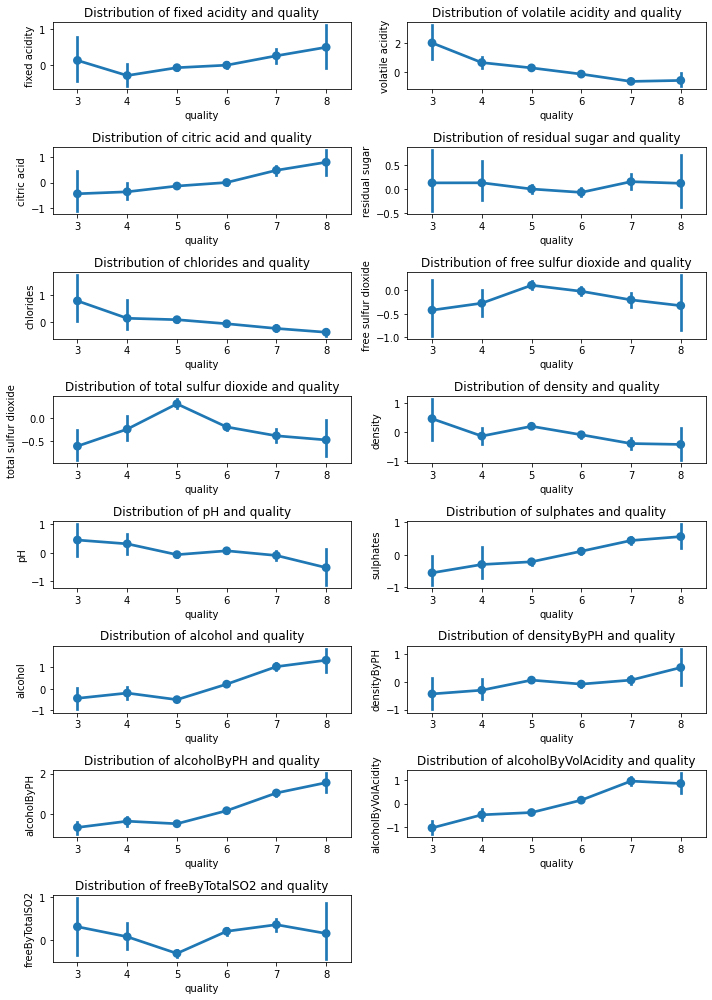

In [50]:
num_feat = ['fixed acidity', 'volatile acidity', 'citric acid', 'residual sugar',
       'chlorides', 'free sulfur dioxide', 'total sulfur dioxide', 'density',
       'pH', 'sulphates', 'alcohol', 'densityByPH', 'alcoholByPH', 'alcoholByVolAcidity', 'freeByTotalSO2']

plt.figure(figsize=(10, 14))
plotTitle = "Distribution of %s and quality"
i = 0
for col in num_feat:
    i+=1
    plt.subplot(8,2,i)
    sns.pointplot(x="quality", y= col , data=trainFeat_df)
    plt.title(plotTitle % (col)) 
    plt.tight_layout()

implement PCA 

In [51]:
from sklearn.decomposition import PCA
pca = PCA(0.95)
pcaData = pca.fit_transform(X_trainFeat)

In [52]:
pcaData.shape

(1199, 9)

In [58]:
keras.backend.clear_session() # clearing session
np.random.seed(42) # generating random see
tf.random.set_seed(42) # set.seed function helps reuse same set of random variables

In [59]:
pcaModel = Sequential([
    Dense(300, input_shape = [9,] , activation = 'selu', kernel_initializer="lecun_normal"),
    Dense(100, activation = 'selu', kernel_initializer="lecun_normal"),
    Dense(100, activation = 'selu', kernel_initializer="lecun_normal"),
    Dense(100, activation = 'selu', kernel_initializer="lecun_normal"),
    Dense(6,  activation = 'softmax')
])

In [60]:
opt = Adam(learning_rate= 0.0001)
loss = 'categorical_crossentropy'
metrics = 'accuracy'
#early_stopping_cb = keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)

pcaModel.compile(optimizer= opt, loss= loss , metrics= [metrics])

In [61]:
pcaHistory = pcaModel.fit(pcaData, y_train, epochs =200)


Train on 1199 samples
Epoch 1/200
1199/1199 [==============================] - 0s 345us/sample - loss: 1.5825 - accuracy: 0.4579
Epoch 2/200
1199/1199 [==============================] - 0s 59us/sample - loss: 1.2243 - accuracy: 0.5480
Epoch 3/200
1199/1199 [==============================] - 0s 55us/sample - loss: 1.1141 - accuracy: 0.5813
Epoch 4/200
1199/1199 [==============================] - 0s 53us/sample - loss: 1.0544 - accuracy: 0.6097
Epoch 5/200
1199/1199 [==============================] - 0s 56us/sample - loss: 1.0106 - accuracy: 0.6188
Epoch 6/200
1199/1199 [==============================] - 0s 58us/sample - loss: 0.9739 - accuracy: 0.6247
Epoch 7/200
1199/1199 [==============================] - 0s 55us/sample - loss: 0.9541 - accuracy: 0.6330
Epoch 8/200
1199/1199 [==============================] - 0s 54us/sample - loss: 0.9335 - accuracy: 0.6339
Epoch 9/200
1199/1199 [==============================] - 0s 56us/sample - loss: 0.9110 - accuracy: 0.6447
Epoch 10/200
1199/1199 

1199/1199 [==============================] - 0s 53us/sample - loss: 0.5544 - accuracy: 0.7882
Epoch 78/200
1199/1199 [==============================] - 0s 52us/sample - loss: 0.5570 - accuracy: 0.7840
Epoch 79/200
1199/1199 [==============================] - 0s 46us/sample - loss: 0.5502 - accuracy: 0.7882
Epoch 80/200
1199/1199 [==============================] - 0s 50us/sample - loss: 0.5490 - accuracy: 0.7940
Epoch 81/200
1199/1199 [==============================] - 0s 46us/sample - loss: 0.5497 - accuracy: 0.7915
Epoch 82/200
1199/1199 [==============================] - 0s 50us/sample - loss: 0.5406 - accuracy: 0.8007
Epoch 83/200
1199/1199 [==============================] - 0s 47us/sample - loss: 0.5403 - accuracy: 0.7923
Epoch 84/200
1199/1199 [==============================] - 0s 50us/sample - loss: 0.5300 - accuracy: 0.8007
Epoch 85/200
1199/1199 [==============================] - 0s 47us/sample - loss: 0.5307 - accuracy: 0.7973
Epoch 86/200
1199/1199 [==========================

1199/1199 [==============================] - 0s 75us/sample - loss: 0.3577 - accuracy: 0.8791
Epoch 153/200
1199/1199 [==============================] - 0s 72us/sample - loss: 0.3627 - accuracy: 0.8666
Epoch 154/200
1199/1199 [==============================] - 0s 61us/sample - loss: 0.3530 - accuracy: 0.8807
Epoch 155/200
1199/1199 [==============================] - 0s 53us/sample - loss: 0.3425 - accuracy: 0.8899
Epoch 156/200
1199/1199 [==============================] - 0s 56us/sample - loss: 0.3402 - accuracy: 0.8916
Epoch 157/200
1199/1199 [==============================] - 0s 57us/sample - loss: 0.3497 - accuracy: 0.8874
Epoch 158/200
1199/1199 [==============================] - 0s 57us/sample - loss: 0.3566 - accuracy: 0.8732
Epoch 159/200
1199/1199 [==============================] - 0s 56us/sample - loss: 0.3443 - accuracy: 0.8882
Epoch 160/200
1199/1199 [==============================] - 0s 57us/sample - loss: 0.3403 - accuracy: 0.8849
Epoch 161/200
1199/1199 [=================

In [63]:
pcatest = pca.transform(X_testFeat)

pcaModel.evaluate(pcatest, y_test)

400/400 [==============================] - 0s 297us/sample - loss: 1.1400 - accuracy: 0.6450


[1.1400495433807374, 0.645]